# Modelo para predecir los datos con redes neuronales
1. Predicción de datos con dependencias no temporales
    1.1 Lineales
    1.2 No lineales
2. Prediccioón de datos con dependencias temporales
    2.1 Lineales
    2.2 No temporales

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import logging
import numpy as np
import pandas as pd
import random as rn
import seaborn as sns
# Añadimos los paths en los que se encuentra
sys.path.append("/home/ledicia.diaz/Projects/Thesis") 

In [3]:
# Import preprocess functions
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split  

# Import backend to build models
import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers

import matplotlib.pyplot as plt
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%d/%M/%y %H:%M:%S')
global_logger = logging.getLogger()

# Para poder estar en modo DEBUG sin que salten warning por el tipo de fuente empleado para cada texto de la imagen
logging.getLogger('matplotlib.font_manager').disabled = True

# 1. Importamos datos

Hay dos tipos de datos:
1. Observaciones independientes en diferentes tiempos. Los datos tendrán la siguiente forma: (observaciones, variables).
2. Observaciones en las que la medida en $t$ de una variable $i$ afecta a la medida en $t'$ de otra variable $j$, donde $t<t'$. Los datos tendrán la siguiente forma: (observaciones, pasos de tiempo de cada serie temporal, variables). Para el algoritmo, estas series de tiempo las podemos tratar de dos maneras diferentes:
    - Cogiendo cada paso de tiempo como una variable independiente para cada una de las observaciones
    - Cogiendo series de tiempo como observación y usando un algoritmo que sea capaz de interpretar estas series de tiempo


In [4]:
import sys
sys.path.append("/home/ledicia.diaz/Projects/Thesis/01_data") 
from load_data import *
from prepare_data import *
from preprocessing_globals import *
from vars_microondas import *

Variable 0 is caused by the following lags [ 6  7  3 12 10  6  9  2 10 12] of variables [0 1 2 3 4 5 6 7 8 9]


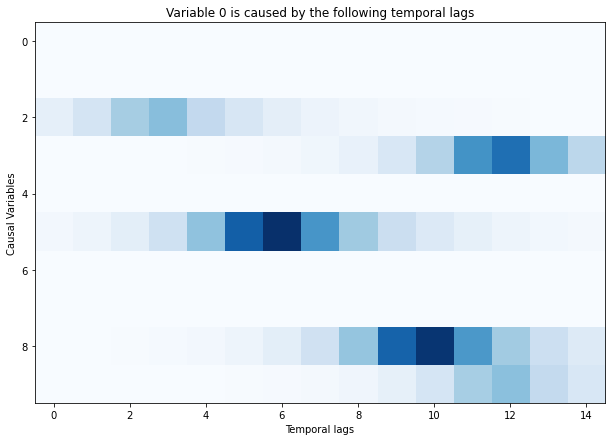

Variable 1 is caused by the following lags [13  3  0  8 13 12  6  6 14 14] of variables [0 1 2 3 4 5 6 7 8 9]


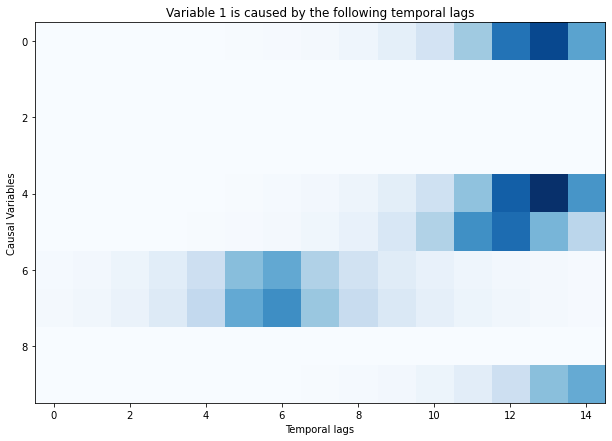

Row variables are dependent variables of the column variables as follows


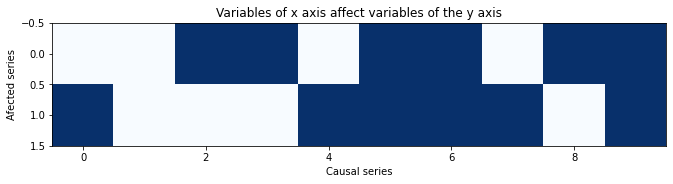

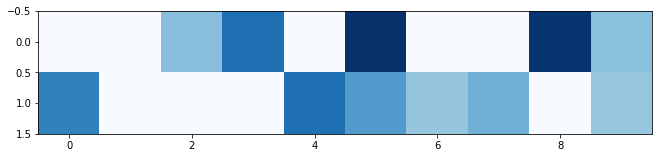

In [12]:
data_type = 'sim2'

if data_type == 'real':
    home_path = '/home/ledicia.diaz/Projects/Thesis/01_data/real_data/'
    #file_name = '21-10-01__22-05-01'
    #file_name = '21-10-01__22-05-01_bm'
    file_name = '22-03-01__22-05-01_M'
    name = home_path + file_name + '.pqt'
    INPUTS = inputs_prueba1
    TARGETS = outputs_ml
    FNN = False
    dataset = load_clean_real_data(name, RENAME_COLS, KEY_DATA, INPUTS, TARGETS, RESAMPLE_FREQ,
                                   FNN, filter_by_prod = False, filter_microwave = True)
    
    if FNN:
        for i in INPUTS+TARGETS:
            dataset = dataset.drop(dataset[dataset[i]<=0].index)

        def drop_2half_std(var, dataset):
            dataset = dataset.drop(dataset[dataset[var]<(dataset[var].mean()-2.5*dataset[var].std())].index)
            dataset = dataset.drop(dataset[dataset[var]>(dataset[var].mean()+2.5*dataset[var].std())].index)
            return dataset

        for var in ['MWPotenciaPV', 'FormacionMWEntT11TempPV', 'FormacionMWEntT11TempPV']:
            dataset = drop_2half_std(var, dataset)
    
elif data_type == 'mixed':
    home_path = '/home/ledicia.diaz/Projects/Thesis/01_data/mixed_data/'
    file_name = 'data'
    name = home_path + file_name+'.csv'
    dataset = load_clean_mixed_data(name, FNN)
    INPUTS = dataset.columns[:8].tolist()
    TARGETS = dataset.columns[8:].tolist()
    dataset = dataset.dropna()
    TARGET = ['Y5']
    
elif data_type == 'sim1':
    home_path = '/home/ledicia.diaz/Projects/Thesis/01_data/sim1_data/'
    file_name = 'data1'
    name = home_path + file_name+'.csv'
    dataset = load_sim1_data(name)
    INPUTS = dataset.columns[:7].tolist()
    TARGETS = dataset.columns[7:].tolist()
    dataset = dataset.dropna()
    
elif data_type == 'sim2':
    T = 15
    file_name = 'TLD_r0_d2nu_s2_p10_T15'
    timeseries = True if file_name[0]=='T' else False
    independent_timesteps = False
    if not independent_timesteps:
        dataset = load_sim2_data(file_name, independent_timesteps)
    else:
        dataset, mapp = load_mixed_data(file_name, independent_timesteps)
    INPUTS = dataset.columns.tolist()[:10]
    TARGETS =dataset.columns.tolist()[10:]
    TARGET = ['S1']

In [17]:
train_set = dataset.iloc[:-10000,:]
test_set = dataset.iloc[-10000:,:]


In [18]:
train_set_norm, test_set_norm, scaler = scale_train_test(StandardScaler(), train_set, test_set, INPUTS, TARGET) 

In [19]:
lag = 30
x_train, x_valid, x_test, y_train, y_valid, y_test = prepare_for_training(train_set_norm, test_set_norm, INPUTS, TARGET, lag)

Info about training set:
Last 15 timesteps of original dataframe are left out becuase they dont fit in a timeseries obs
Data shape (Observations, timesteps, features) = (32999, 30, 11)
Input shape (Observations, timesteps, inputs) = (32999, 30, 10)
Output shape (Observations, timesteps, targets) = (32999, 1)
Info about testing set:
Data shape (Observations, timesteps, features) = (9970, 30, 11)


# Create model

In [20]:
def reproducible_results(seed):
        '''
        - REPRODUCIBILITY: necessary for starting Numpy generated random numbers in a well-defined 
            - 1. initial state
            - 2. state
        '''
        np.random.seed(seed)
        rn.seed(seed)
        tf.random.set_seed(seed)

reproducible_results(1234)

In [21]:
from utils.keras_callbacks import *
from tqdm.keras import TqdmCallback
tqdm_callback = TqdmCallback(verbose=0)
LambdaCallback = keras.callbacks.LambdaCallback
print_weights = LambdaCallback(on_epoch_end=lambda epoch, logs: print(model.layers[1].get_weights()))

# Diccionario de hiperparametros para entrenar la red
hyperparam = {
    'optim': dict(learning_rate = 0.01, momentum = 0.9, nesterov=False),
    'fit': dict(epochs = 100, batch_size=128, shuffle=True,
                callbacks = [
                    tfk.callbacks.TerminateOnNaN(),
                    tfk.callbacks.EarlyStopping(patience=10),
                    tfk.callbacks.ReduceLROnPlateau(min_lr=0.000001, patience=5),
                    tqdm_callback,
#                     FirstLayerWeightCallback(),
#                     print_weights,
#                     GradientCallback(),
                        ],
                ),
            }

0epoch [00:00, ?epoch/s]

In [22]:
import json
from keras_models import *
tf.keras.backend.clear_session()
from pathlib import Path
from utils.model_utils import *
#from Prediction_models.Keras_models import*

load_model_flag = False
timeseries=True
no_batches=False
independent_timesteps = False


if load_model_flag:
    MODEL_NAME = 'timeseries_data_SL_c0_m2_T15_lagT'
    MODEL_PATH = './Selection_Layer/Models/'
    model_path=Path(MODEL_PATH)
    
    model = load_model(model_path = model_path / MODEL_NAME, custom_objects = {"CancelOutRNN":CancelOutRNN})
    model.summary()
    
    # Get cancelout_activation
    with open(MODEL_PATH+MODEL_NAME+'/model_architecture.json', 'r') as f:
        data = json.load(f)
        cancelout_activation = data['config']['layers'][1]['config']['activation']
else:
    cancelout_activation = 'custom_relu'
    cancelout_loss = False
    lambda1 = 0.02
    lambda2 = 0
    if timeseries:
        if independent_timesteps:
            if no_batches:
                model = MLP_CNN(x_train, lag, hyperparam)
            else:
#                 model = MLP(x_train, hyperparam)
               model = MLP_elector(
    x_train, cancelout_activation = cancelout_activation, cancelout_loss = False)
        else:
            #model = RNN_Selector__(x_train, cancelout_activation, cancelout_loss, lambda1, lambda2)
            model = MLP_TS_Selector(x_train, cancelout_activation, cancelout_loss, lambda1, lambda2)
#             model = CNN_Selector(x_train, T, cancelout_activation, cancelout_loss, lambda1, lambda2)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 10)]          0         
                                                                 
 cancel_out_rnn (CancelOutRN  (None, 30, 10)           300       
 N)                                                              
                                                                 
 flatten (Flatten)           (None, 300)               0         
                                                                 
 dense (Dense)               (None, 100)               30100     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                             

2022-06-20 15:55:08.390358: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 15:55:08.422551: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-06-20 15:55:08.422567: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-06-20 15:55:08.423038: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

In [23]:
if not load_model_flag:
    tqdm_callback.display()
    model.fit(x=x_train, y=y_train, validation_data=(x_valid,y_valid), verbose=0, **hyperparam['fit'])

    # list_callbacks=[keras.callbacks.TerminateOnNaN(),tf.keras.callbacks.TensorBoard(log_dir="/tmp/model_logs"),
    #                 keras.callbacks.ReduceLROnPlateau(min_lr=0.000001, patience=5)]
    # model.fit(x=x_train,y=y_train,epochs=100, batch_size=64,shuffle=True, callbacks=list_callbacks,validation_data=(x_valid,y_valid))

0epoch [00:02, ?epoch/s]

In [24]:
y_train.shape

(29699, 1)

In [25]:
predictions = model.predict(x_test)
results = pd.DataFrame.from_dict({
        "Date": np.arange(y_test.shape[0]),  # "fecha": set4testingmodel.index,
        "prediction": predictions.ravel(),
        "real": y_test.ravel(),
                                    }).set_index("Date")
true_col = 'real'
pred_col = 'prediction'

In [26]:
from utils.prediction_utils import *

output_norm = True
if output_norm:
    predicciones_denorm = denorm_pred(scaler, train_set, results, true_col, pred_col, TARGETS, denorm_true_col = True)
else: 
    predicciones_denorm = results

20/56/22 15:56:19 DEBUG:Denormalizing outputs: Predicted variable


20/56/22 15:56:20 DEBUG:Loaded backend module://matplotlib_inline.backend_inline version unknown.
20/56/22 15:56:20 DEBUG:Loaded backend module://matplotlib_inline.backend_inline version unknown.


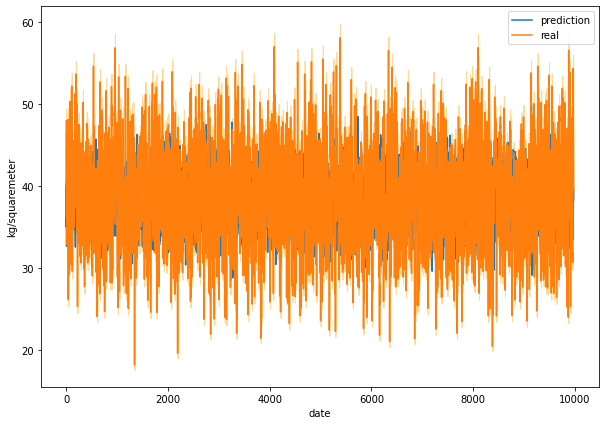

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
from utils.prediction_plots import *
plt.rcParams['figure.figsize'] = [10,15]

%matplotlib inline
plt.rcParams['figure.figsize'] = [10,7]
plot_results(predicciones_denorm.iloc[:], true_col, pred_col, plot_dates=True)

20/56/22 15:56:26 DEBUG:Loaded backend module://matplotlib_inline.backend_inline version unknown.


[(1, 5.015045135406218),
 (2, 10.090270812437312),
 (3, 14.784353059177532),
 (4, 19.62888665997994),
 (5, 24.964894684052155),
 (6, 29.608826479438317),
 (7, 34.09227683049147)]

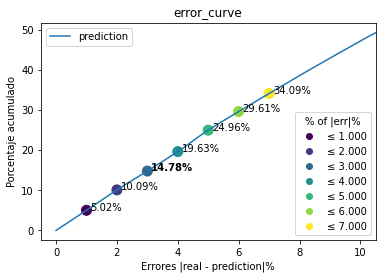

In [28]:
%matplotlib inline
print_error_curve(
    df=predicciones_denorm,
    target_col=true_col,
    pred_col=pred_col,
    values=np.arange(1,8),
    is_percentual=True,
    annotate = "right")

# Feature Importance

Indica que variables entran en la red neuronal.

In [29]:
from keras_selection_layer import custom_relu
cancelout_weights=model.get_weights()[0]
if cancelout_activation == 'linear': importances = cancelout_weights
if cancelout_activation == 'relu': importances = tf.nn.relu(cancelout_weights).numpy()
if cancelout_activation == 'sigmoid': importances = tf.sigmoid(cancelout_weights).numpy()
if cancelout_activation == 'softmax': importances = tf.nn.softmax(cancelout_weights).numpy()
if cancelout_activation == 'custom_relu': importances = custom_relu(cancelout_weights).numpy()
indices = np.argsort(importances)

20/56/22 15:56:28 DEBUG:Loaded backend module://matplotlib_inline.backend_inline version unknown.


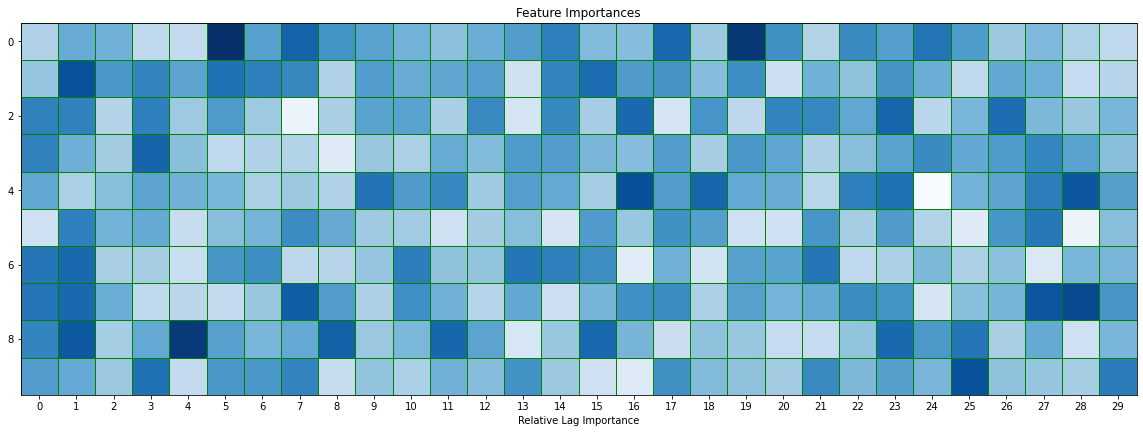

In [30]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10,7]
if timeseries:
    if independent_timesteps:
        plt.title('Feature Importances')
        importances = importances.reshape(11,T)
        plt.imshow(importances, cmap = 'Blues')  
#         plt.barh(range(len(indices)), importances[indices], color='b', align='center')
#         plt.yticks(range(len(indices)), [i for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()
    else:
        fig, ax = plt.subplots(figsize=(20, 10))
        plt.title('Feature Importances')
        ax.imshow(importances.T, cmap = 'Blues')  
        ax.set_xticks(np.arange(importances.shape[0]))
        plt.xlabel('Relative Lag Importance')
        for i in range(importances.shape[0]):
            for j in range(importances.shape[1]):
                if importances[i,j] > 0.0:
                    rect = plt.Rectangle((i-0.5, j-0.5), 1, 1, facecolor='none', edgecolor='green', linewidth=1.0)
                    ax.add_patch(rect)
        plt.show()
else:
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [i for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

# Sensitivity Plot 

Indica cuan importante es cada variable en media para la red neuronal

In [ ]:
from utils.sensitivity_utils import *
R = model_sensitivity(x_test[15:30], model)

In [ ]:
R_mean = np.mean(R, axis = 0).T
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(R_mean, cmap = 'Blues')  
ax.set_xticks(np.arange(R.shape[1]))
# Mark nonzeros
for i in range(R_mean.shape[1]):
    for j in range(R_mean.shape[0]):
        if R_mean[j, i] > 0.0:
            rect = plt.Rectangle((i-0.5, j-0.5), 1, 1, facecolor='none', edgecolor='green', linewidth=1.0)
            ax.add_patch(rect)
plt.show()

# Save model

In [ ]:
train_set_norm, test_set_norm, scaler = norm_data_for_training(StandardScaler(), train_set, test_set, INPUTS, [TARGET], output_norm = output_norm)

In [ ]:
from pathlib import Path
from utils.model_utils import *

if not timeseries:
    MODEL_NAME = folder+"_SL_c"+str(c)+'_m'+str(m)+'without11'
    config = {
        "MODEL_ID": f"\"{MODEL_NAME}\"",
        "INPUTS": "\"" + ",".join(INPUTS) + "\"",
        "OUTPUTS": "\"" + " ".join(TARGET) + "\"",
        "INPUT_NORMALIZATION": input_norm,
        "OUTPUT_NORMALIZATION": output_norm,
        "NORMALIZATION_TYPE": scaler,
        "DATA_TYPE": "'c='" + f"\"{c}\""+"'m='" + f"\"{m}\"",
    }
else:
    MODEL_NAME = file_name
    config = {
        "MODEL_ID": f"\"{MODEL_NAME}\"",
        "INPUTS": "\"" + ",".join(INPUTS) + "\"",
        "OUTPUTS": "\"" + " ".join(TARGET) + "\"",
        "INPUT_NORMALIZATION": input_norm,
        "OUTPUT_NORMALIZATION": output_norm,
        "NORMALIZATION_TYPE": scaler,
        "TIME_STEPS_IN_PATTERN": T,
        #"DATA_TYPE": "'c='" + f"\"{c}\""+"'m='" + f"\"{m}\"",
    }


model_path=Path('./Models_keras/')
save_model(model, path=model_path / MODEL_NAME,
    config=config,
    scaler=scaler,
    cols=train_set_norm[INPUTS+[TARGET]].columns, # cols to save csv with mean and std 
    deploy_model=True,
)

In [ ]:
x_test.shape

In [ ]:
plot_sensitivity(R)